# Classification of ag plastics across California

Sentinel-2 classification of agricultural plastic use in California based on Harvard students' capstone project and Yuanyuan's internship project

Notebook authored by Annie Taylor, July 2024

Some key changes from previous analyses:
* Using validated training datasets (edited, added precise dates)
* Using different cloud-masking algorithm
* Using updated index equations
* Random stratified sample within polygons instead of sampling every point

### Set up ee api

In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from datetime import datetime, timedelta
from sklearn.metrics import ConfusionMatrixDisplay
import geopandas

In [2]:
# ee.Authenticate(auth_mode='localhost')
ee.Initialize(project='ee-annalisertaylor')

### Load data

In [3]:
assets = 'projects/ee-annalisertaylor/assets/TNC/agplastics/'

# Yuanyuan's data, not using this anymore
oxnard_bnd = ee.FeatureCollection(assets + 'Oxnard')
label_mulch_hoop = ee.FeatureCollection(assets + 'label_mulch_hoop')
label_nonplastic = ee.FeatureCollection(assets + 'label_nonplastic')
polygons = label_mulch_hoop.merge(label_nonplastic)
aoi_truck_crop = ee.FeatureCollection(assets + 'T')
# strawberries = ee.FeatureCollection(assets + 'Strawberries')
# bushberries = ee.FeatureCollection(assets + 'Bushberries_T19')
# flowers = ee.FeatureCollection(assets + 'Flowers_T16')
# peppers = ee.FeatureCollection(assets + 'Peppers_T21')
# avocados = ee.FeatureCollection(assets + 'Avocados')

# Load data from counties
fc_SantaMaria = ee.FeatureCollection(assets + 'SantaMaria_val')
fc_Mendocino = ee.FeatureCollection(assets + 'Mendocino_val') # amount might be neglible
fc_Watsonville = ee.FeatureCollection(assets + 'Watsonville_val')
fc_Oxnard = ee.FeatureCollection(assets + 'Oxnard_val')
# filter out a date from that fc with no images, only 29 points
fc_Oxnard = fc_Oxnard.filter(ee.Filter.neq('Date', '11/19/2018'))

# TODO could change the script to use csvs in repo
# Or combine them all into one csv/fc, would just have to change the sampling functions
# train_path = "data/Validated_Training_Data/"
# santamaria = pd.read_csv(train_path + 'SantaMaria_val.csv')
# mendocino = pd.read_csv(train_path + 'Mendocino_val.csv')
# watsonville = pd.read_csv(train_path + 'Watsonville_val.csv')
# oxnard_pts = pd.read_csv(train_path + 'YYT_labeled_points.csv')
# oxnard_pts = geopandas.read_file('N:/OCEANS_Program/projects/Plastics/Agricultural_Plastics/Validated Training Data/YYT_RElabeled_points.shp')

# Encode labels
class_mapping = {'hoop': 0, 'mulch': 1, 'other': 2, 'greenhouse': 3}
# only watsonville has greenhouse points right now, santa maria has a separate (unimported) dataset

# California boundary
ca = ee.FeatureCollection("TIGER/2018/States").filter(ee.Filter.equals('NAME', 'California'))
# Agricultural areas from CA DWR's crop maps, 2019 to 2022 inclusive (10m raster)
crops = ee.Image('projects/ee-annalisertaylor/assets/TNC/agplastics/dwr_allyears')

## 1. Process Sentinel-2 Imagery

### Cloud filter the image collection

In [5]:
startDate = ee.Date.fromYMD(2010, 1, 1) # setting these to be inclusive for now, can change
endDate = ee.Date.fromYMD(2025, 10, 1)

s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filter(ee.Filter.date(startDate, endDate)) \
    .filter(ee.Filter.bounds(ca)) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_OVER_LAND_PERCENTAGE', 92)) #trying another property for clouds covering land
    # .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 92))

#### Cloud filtering with the s2_cloudless collection

In [ ]:
# cloud mask using the cloudless image collection, pulling from EE documentation example
s2cloud = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
s2cloud = s2cloud.filterBounds(ca)
MAX_CLOUD_PROBABILITY = 15

def maskClouds(img):
    clouds = ee.Image(img.get('cloud_mask')).select('probability')
    isNotCloud = clouds.lt(MAX_CLOUD_PROBABILITY)
    return img.updateMask(isNotCloud)

# Masks for the 10m bands can include bad data at scene edge; apply masks from the 20m and 60m bands too
def maskEdges(s2_img):
    return s2_img.updateMask(s2_img.select('B8A').mask().updateMask(s2_img.select('B9').mask()))

# So I can investigate how this is performing above plastic cover
def addCloudless(img):
    cloud_prob = ee.Image(img.get('cloud_mask')).select('probability')
    return img.addBands(cloud_prob.rename('cloud_probability'))

# Filter s2cloud to same region, fix 10m pixels at edges
s2_mask = s2.map(maskEdges)

# Join S2 with cloud probability dataset to add cloud mask
# cloudless image is saved as a property called 'cloud_mask' in the original image
s2sr_cloudmask = ee.Join.saveFirst('cloud_mask').apply(primary=s2_mask, secondary=s2cloud, \
                            condition=ee.Filter.equals(leftField='system:index', rightField='system:index'))

# create the cloud masked image collection
s2_cldmsk = ee.ImageCollection(s2sr_cloudmask).map(maskClouds)

# create an image collection with the cloud probability band, not yet masked
# this is for testing to see what values certain pixels have
s2_cld_test = ee.ImageCollection(s2sr_cloudmask).map(addCloudless)

#### Cloud filtering with the QA band 
After seeing problems with the s2_cloudless filter, but apparently this band doesn't contain any info from feb 2022 to feb 2024 so it's not usable

In [18]:
def mask_s2_clouds(image):
   qa = image.select('QA60')
   # Bits 10 and 11 are clouds and cirrus, respectively.
   cloud_bit_mask = 1 << 10
   cirrus_bit_mask = 1 << 11
   # Both flags should be set to zero, indicating clear conditions.
   mask = (qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0)))
   return image.updateMask(mask)

s2_qa_cldmsk = s2.map(mask_s2_clouds)

#### Cloud filtering with MSK_CLDPRB band

In [22]:
cloud_threshold = 10

def mask_s2_clouds_cm(image):
   cm = image.select('MSK_CLDPRB')
   isNotCloud = cm.lt(MAX_CLOUD_PROBABILITY)
   return image.updateMask(isNotCloud)

s2_cm_cldmsk = s2.map(mask_s2_clouds_cm)

#### Cloud filtering with the SCL band

In [29]:
# 8 = Clouds Medium Probability
# 9 = Clouds High Probability
# 10 = Cirrus

def mask_s2_clouds_scl(image):
    scl = image.select('SCL')
    isNotCloud = scl.neq(8).And(scl.neq(9).And(scl.neq(10)))
    return image.updateMask(isNotCloud)

s2_scl_cldmsk = s2.map(mask_s2_clouds_scl)

#### Vis params

In [23]:
rgbVis = {'min': 400, 'max': 1500, 'bands': ['B4', 'B3', 'B2']}

### Add VIs

In [24]:
def addNBR_RS(image):
    # reduces the resolution of the NIR band (10m) to match the SWIR band (20m)
    #   using the mean of all pixels within the larger pixel
    swir = image.select('B12')
    swir_projection = swir.projection()
    nir = image.select('B8').reduceResolution(reducer=ee.Reducer.mean(), maxPixels=16).reproject(crs=swir_projection)
    js_math_exp = 'c = (a-b) / (a+b)'
    js_math_img = ee.Image().expression(
        expression=js_math_exp, opt_map={'a': nir, 'b': swir}
    ).rename('NBR_RS')
    image = image.addBands(js_math_img)
    return image

def addVIs(image):
    image = image.addBands(image.normalizedDifference(['B8', 'B4']).rename('NDVI'))
    # image = image.addBands(image.normalizedDifference(['B8', 'B12']).rename('NBR')) # one band at 20m
    # image = image.addBands(image.normalizedDifference(['B8', 'B11']).rename('NDMI')) # one band at 20m
    # image = image.addBands(image.normalizedDifference(['B3', 'B8']).rename('NDWI'))
    # image = image.addBands(image.expression("2.5 * ((b('B8') - b('B4')) / (b('B8') + 6 * b('B4') - 7.5 * b('B2') + 1))").rename('EVI'))
    image = image.addBands(image.normalizedDifference(['B11', 'B12']).rename('NDTI')) # swir1 and swir2, both 20m
    image = image.addBands(image.expression("(100 * b('B2') * (b('B8') - b('B4')))/(1 - ((b('B2') + b('B3') + b('B8')) / 3))").rename('PGI'))
    image = image.addBands(image.expression("b('B2')/(1 - ((b('B2') + b('B3') + b('B8')) / 3))").rename('RPGI'))
    image = image.addBands(image.normalizedDifference(['B11', 'B4']).rename('PMLI')) # one band at 20m
    image = image.addBands(image.normalizedDifference(['B11', 'B8']).rename('NDBI')) # one band at 20m    
    return image

# def adjPGI(image):
    # make PGI = 0 where NDVI is higher than __ and NDBI is lower than ___. 
    # add it to image as PGI_adj



### Build the collection

In [32]:
# one for each method of cloud filtering, for comparison
processedCollection = s2_cldmsk.map(addVIs)
processedCollection_qa = s2_qa_cldmsk.map(addVIs)
processedCollection_cm = s2_cm_cldmsk.map(addVIs)
processedCollection_scl = s2_scl_cldmsk.map(addVIs)
# print(processedCollection.size().getInfo())
print(processedCollection.first().bandNames().getInfo())

['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12', 'AOT', 'WVP', 'SCL', 'TCI_R', 'TCI_G', 'TCI_B', 'MSK_CLDPRB', 'MSK_SNWPRB', 'QA10', 'QA20', 'QA60', 'MSK_CLASSI_OPAQUE', 'MSK_CLASSI_CIRRUS', 'MSK_CLASSI_SNOW_ICE', 'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI', 'NDBI']


In [33]:
# start = '2023-04-26'
# end = '2023-05-16'
# images = processedCollection.filterBounds(oxnard_bnd).filterDate(start, end)
# print(images.size().getInfo())

# m = geemap.Map()
# m.addLayer(oxnard_bnd)
# m.addLayer(images)
# m.centerObject(oxnard_bnd)
# m

# recent = images.sort('system:index', False).limit(10)
# recent

In [34]:
# Select bands to use to train the model
bands = [
    'B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12',
    'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI'
]

#### investigate cloud filtering issues

In [35]:
# processedCollection = final collection with VIs added
# processedCollection2 = final collection with VIs added, using QA60 band for cloud filtering
# s2_cldmsk = cloud filtered version
# s2_qa_cldmsk = cloud filtered version using QA60 band
# s2_cm_cldmsk = cloud filtered version using MSK_CLDPRB band
# s2_cld_test = s2 with s2_cloudless data joined, not yet filtered
# s2 = original collection, filtered by date/ca/image cloudiness lt 92

# grab county boundaries for spatial filtering 
county_bnd = ee.FeatureCollection("TIGER/2016/Counties").filterBounds(ca)
# grab whatever counties you want
ventura = county_bnd.filter(ee.Filter.eq('NAME', 'Ventura'))
mendo = county_bnd.filter(ee.Filter.eq('NAME', 'Mendocino'))
cruz = county_bnd.filter(ee.Filter.eq('NAME', 'Santa Cruz'))
santabarbara = county_bnd.filter(ee.Filter.eq('NAME', 'Santa Barbara'))

co = cruz
images_original = processedCollection.filterBounds(co)
# test_s2 = s2.filterBounds(co)
images_cloudless = s2_cld_test.filterBounds(co) # get the original image with s2_cloudless probability added
images_cm = processedCollection_cm.filterBounds(co)
images_scl = processedCollection_scl.filterBounds(co)

start = '2022-01-01'
end = '2022-03-30'

original = images_original.filterDate(start, end).first()
original_cloudless = images_cloudless.filterDate(start, end).first()
cm = images_cm.filterDate(start, end).first()
scl = images_scl.filterDate(start, end).first()
# test3 = test_processedCollection.filterDate('2021-05-18', '2021-05-20').first()
# test4 = test_s2.filterDate('2021-05-18', '2021-05-20').first()
# test5 = test_processedCollection.filterDate('2020-03-24', '2020-03-26').first()
# test6 = test_s2.filterDate('2020-03-24', '2020-03-26').first()
# test7 = test_processedCollection.filterDate('2022-12-04', '2022-12-06').first()
# test8 = test_s2.filterDate('2022-12-04', '2022-12-06').first()
# test9 = test_s2.filterDate('2022-11-04', '2022-11-30').first()

# map with individual test images added
m = geemap.Map()
m.addLayer(original, rgbVis, 'cloud filtered')
m.addLayer(cm, rgbVis, 'cloud filtered CLDPRB')
m.addLayer(scl, rgbVis, 'cloud filtered SCL')
m.addLayer(original_cloudless, rgbVis, 'original image')
# m.addLayer(test_cloud, rgbVis, 'cloud data IC')
# m.addLayer(test3, rgbVis, 'May 19 2021: cloud filtered', False)
# m.addLayer(test4, rgbVis, 'May 19 2021: original image', False)
# m.addLayer(test5, rgbVis, 'March 25 2020: cloud filtered', False)
# m.addLayer(test6, rgbVis, 'March 25 2020: original image', False)
# m.addLayer(test7, rgbVis, 'Dec 5 2022: cloud filtered', False)
# m.addLayer(test8, rgbVis, 'Dec 5 2022: original image', False)
# m.addLayer(test9, rgbVis, 'november 2022', False)
m.centerObject(test1, 8)
m

# # map with time slider, change years
# m = geemap.Map()
# m.add("basemap_selector")
# m.centerObject(co, 8)
# # 4 day time interval captures every sentinel-2 image
# m.add_time_slider(test_processedCollection.filterDate('2023-02-01','2023-04-01'), rgbVis, time_interval=4)
# m.addLayer(ee.Image().toByte().paint(co, 0, 2), {'palette': '111111'}, 'County Boundary')
# m

Map(center=[37.45118591731683, -122.37966239140695], controls=(WidgetControl(options=['position', 'transparent…

### Functions to sample image mosaics for certain dates and places

In [11]:
def get_collection_on_date(df, county, date, roi):
    # Filter for date
    df_date = df[df["Date"]==date]

    # Get coordinates as a list
    points = []
    for idx, row in df_date.iterrows():
        point = ee.Geometry.Point([row['Longitude'], row['Latitude']])
        feature = ee.Feature(point, {'class': row['NumericType']})
        points.append(feature)
    
    fc = ee.FeatureCollection(points)
    # Get image for a month's range
    date_ = datetime.strptime(date, "%Y-%m-%d")
    start = (date_ - timedelta(days=10)).strftime("%Y-%m-%d")
    end = (date_ + timedelta(days=10)).strftime("%Y-%m-%d")

    trimmedCollection = processedCollection.filterDate(start, end).filterBounds(roi)
    image = trimmedCollection.median()# I don't think you need to.clip(roi)
    # roi = minimum bounds from training points lat/lon
    
    # Sample points from image
    data = image.select(bands).sampleRegions(
        collection=fc,
        properties=['class'],
        scale=10,
        geometries=True
    )
    # Add 'date' as a property to each feature in the feature collection
    data = data.map(lambda feature: feature.set('date', date))
    print(f"Total number of labeled data for {date} in {county}:", data.size().getInfo())
    # returns a fc
    return data

In [12]:
# already defined above
# class_mapping = {'hoop': 0, 'mulch': 1, 'other': 2, 'greenhouse': 3}

def processCountyFeatureCollection(fc, county):
    # Make dataframe 
    # TODO use geemap fc to df function
    dict_list = [feat['properties'] for feat in fc.getInfo()['features']]
    df = pd.DataFrame(dict_list)
    # Encode labels
    df['NumericType'] = df['Type'].map(class_mapping)
    # Drop greenhouse type (for now)
    df = df[df["Type"]!="greenhouse"]
    # Format dates to YYYY-MM-DD
    df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
    # Filter for dates when Sentinel-2 is available
    df = df[df['Date'] > '2018-05-09']
    
    # County boundaries based off csv coordinates
    min_lon = df['Longitude'].min()
    max_lon = df['Longitude'].max()
    min_lat = df['Latitude'].min()
    max_lat = df['Latitude'].max()
    roi = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])
    
    # Iterate through unique dates
    # df = df[df.groupby('Date')['Date'].transform('size') > 100]
    # dateslist = df["Date"].value_counts()
    dates = df["Date"].unique()
    all_county_data = []
    
    for date in dates:
        all_county_data.append(get_collection_on_date(df, county, date, roi))
    # all_county_data is a list of feature collections, same number as dates for that county
    county_fc = ee.FeatureCollection(all_county_data).flatten()
    # add the county name as a property to each feature
    def addCountyProperty(feature):
        return feature.set('county', county)
    county_fc = county_fc.map(addCountyProperty)
    print(f"Total number of labeled data in {county}:", county_fc.size().getInfo())
    return county_fc

## 2. Sample each feature collection to build training dataset
Skip to 2b for faster running code if you haven't made changes to imagery / sampling methods

In [15]:
data_Mendocino = processCountyFeatureCollection(fc_Mendocino, "Mendocino")

# df_mendo = geemap.ee_to_gdf(data_Mendocino)
# display(df_mendo)
# data_Mendocino.limit(5)

Total number of labeled data for 2021-06-02 in Mendocino: 262
Total number of labeled data in Mendocino: 262


In [16]:
data_SantaMaria = processCountyFeatureCollection(fc_SantaMaria, "Santa Maria")

Total number of labeled data for 2022-08-26 in Santa Maria: 69
Total number of labeled data for 2023-05-05 in Santa Maria: 166
Total number of labeled data for 2022-03-10 in Santa Maria: 242
Total number of labeled data for 2021-02-06 in Santa Maria: 119
Total number of labeled data in Santa Maria: 596


In [17]:
data_Watsonville = processCountyFeatureCollection(fc_Watsonville, "Watsonville")

Total number of labeled data for 2020-09-26 in Watsonville: 272
Total number of labeled data for 2021-09-27 in Watsonville: 388
Total number of labeled data for 2022-09-11 in Watsonville: 347
Total number of labeled data for 2023-04-12 in Watsonville: 369
Total number of labeled data in Watsonville: 1376


In [19]:
data_Oxnard = processCountyFeatureCollection(fc_Oxnard, "Oxnard")

Total number of labeled data for 2019-10-14 in Oxnard: 23
Total number of labeled data for 2023-05-06 in Oxnard: 496
Total number of labeled data for 2023-11-09 in Oxnard: 174
Total number of labeled data for 2019-05-17 in Oxnard: 116
Total number of labeled data for 2022-09-21 in Oxnard: 7
Total number of labeled data for 2019-08-19 in Oxnard: 15
Total number of labeled data for 2020-02-15 in Oxnard: 40
Total number of labeled data for 2021-07-13 in Oxnard: 80
Total number of labeled data for 2022-06-13 in Oxnard: 151
Total number of labeled data for 2023-05-07 in Oxnard: 32
Total number of labeled data for 2023-05-11 in Oxnard: 17
Total number of labeled data for 2023-10-17 in Oxnard: 121
Total number of labeled data for 2022-11-01 in Oxnard: 67
Total number of labeled data for 2019-04-01 in Oxnard: 14
Total number of labeled data for 2022-10-01 in Oxnard: 64
Total number of labeled data in Oxnard: 1417


##### Debugging oxnard data

In [15]:
# # Make dataframe
# dict_list = [feat['properties'] for feat in fc_Oxnard.getInfo()['features']]
# df = pd.DataFrame(dict_list)
# # Encode labels
# df['NumericType'] = df['Type'].map(class_mapping)
# # Drop greenhouse type (for now)
# df = df[df["Type"]!="greenhouse"]
# # Format dates to YYYY-MM-DD
# df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%Y-%m-%d')
# # Filter for dates when Sentinel-2 is available
# df = df[df['Date'] > '2018-05-09']

# # County boundaries based off csv coordinates
# min_lon = df['Longitude'].min()
# max_lon = df['Longitude'].max()
# min_lat = df['Latitude'].min()
# max_lat = df['Latitude'].max()
# roi = ee.Geometry.Rectangle([min_lon, min_lat, max_lon, max_lat])

# # start = '2023-04-26'
# # end = '2023-05-16'
# # images = processedCollection.filterDate(start, end).filterBounds(roi)
# # print(images.size().getInfo())
# dateslist = df["Date"].value_counts()

# date = '2018-11-19'
# dates = df["Date"].unique()
# display(dates)
# display(dateslist)

# # Filter for date
# df_date = df[df["Date"]==date]

# # Get coordinates as a list
# points = []
# for idx, row in df_date.iterrows():
#     point = ee.Geometry.Point([row['Longitude'], row['Latitude']])
#     feature = ee.Feature(point, {'class': row['NumericType']})
#     points.append(feature)

# fc = ee.FeatureCollection(points)
# # Get image for a month's range
# date_ = datetime.strptime(date, "%Y-%m-%d")
# start = (date_ - timedelta(days=10)).strftime("%Y-%m-%d")
# end = (date_ + timedelta(days=10)).strftime("%Y-%m-%d")

# trimmedCollection = processedCollection.filterDate(start, end).filterBounds(roi)
# image = trimmedCollection.median()# I don't think you need to.clip(roi)
# # roi = minimum bounds from training points lat/lon

# # Sample points from image
# data = image.select(bands).sampleRegions(
#     collection=fc,
#     properties=['class'],
#     scale=10,
#     geometries=True
# )

# # display(data)
# print(data.size().getInfo())
# # m = geemap.Map()
# # m.addLayer(image)
# # m.addLayer(roi)
# # m.centerObject(roi)
# # m

##### Load data for Oxnard - old
changing this to 2023 because Yuanyuan used mostly gee basemap imagery during summer of 2023

In [16]:
# START = '2023-02-01'
# END = '2023-06-01'

# trimmedCollection = processedCollection.filterDate(START, END).filterBounds(oxnard_bnd)
# image = trimmedCollection.median()

# # stratified sample of the oxnard_pts to avoid memory limit cap
# oxnard_pts['class'] = oxnard_pts['CID']
# # oxnard_pts = oxnard_pts.reset_index()
# # oxnard_pts = oxnard_pts.groupby('class').apply(lambda x: x.sample(frac=0.8))
# oxnard = geemap.geopandas_to_ee(oxnard_pts).limit(800)

# data_Oxnard = image.sampleRegions(
#     collection=oxnard,
#     properties=['class'],
#     scale=10,
#     geometries=False
# )
# print(f"Total number of labeled data in Oxnard:", data_Oxnard.size().getInfo())

# # batching it example from other work
# # diff version with chunk_cover as the region
# def RR_all_features(img):
#     fc_means = ee.FeatureCollection(img.reduceRegions(chunk_cover, ee.Reducer.mean(), 10))
#     img_date = img.date().format("MM-dd-YYYY")
#     img_wy = img.get('system:index')
#     def set_date(feat):
#         return feat.set({'Date': img_date, 'WaterYear': img_wy})
#     fc_means = ee.FeatureCollection(fc_means.map(set_date))
#     return fc_means

# # Separate the points into chunks of 1000, run reduceRegions to get stats, and then recombine into one df
# chunks = [0, 1000, 2000]
# add_dfs = []

# for i in range(len(chunks)-1):
#     chunk_cover = sub_cover.iloc[chunks[i]:chunks[i+1]] # sub-sample the full df 
#     chunk_cover = geemap.geopandas_to_ee(chunk_cover) # convert to ee fc
#     result = ee.FeatureCollection(annualMetricsSelected.map(RR_all_features)).flatten()
#     chunk_df = geemap.ee_to_df(result)
#     add_dfs.append(chunk_df)
    
# recombined_dfs = pd.concat(add_dfs, ignore_index=True)

#### Combine sampled training data

In [20]:
# Combine all data
all_data = []
all_data.append(data_SantaMaria)
all_data.append(data_Mendocino)
all_data.append(data_Watsonville)
all_data.append(data_Oxnard)

# random column for training/validation split
data = ee.FeatureCollection(all_data).flatten().randomColumn(seed=0)
# df = geemap.ee_to_df(data) # useful for stats calculations/visualization

In [22]:
# save the fc as an asset to drastically speed up later anaylsis
# have to delete this asset first, can't overwrite it
# asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/labeled_point_data'

# task = ee.batch.Export.table.toAsset(
#     collection=data,
#     description='Export training data to asset',
#     assetId=asset_id
# )
# task.start()

## 2b Import fc instead of building it

In [13]:
# import that fc back
asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/labeled_point_data'
data = ee.FeatureCollection(asset_id)

## 3. Split training and validation data

In [14]:
# Process data (1): Train test split
# print(f"Total number of labeled data:", data.size().getInfo())
split = 0.7
training = data.filter(ee.Filter.lt('random', split))
validation = data.filter(ee.Filter.gte('random', split))
# print(f"Number of training points: {training.size().getInfo()}")
# print(f"Number of validation points: {validation.size().getInfo()}")

#### Training data stats

In [15]:
# convert to dfs for easier stats
# training_df = geemap.ee_to_df(training)
# validation_df = geemap.ee_to_df(validation)

# print(f"Number of training points: {training_df.shape[0]}")
# print(f"Number of validation points: {validation_df.shape[0]}")

# Check number of data in each county
# print("Number of training points:", training_df['county'].value_counts())
# print("Number of validation points:", validation_df['county'].value_counts())

#### Address spatial autocorrelation
- Remove points within 30 min of each other between the training and validation datasets
- DOES NOT ADDRESS SPATIAL AUTOCORRELATION W/IN THESE DATASETS and also the fact that many of these points are from different dates :/ 

In [16]:
# Process data (2): Address autocorrelation correction
# TODO how are we addressing spatial autocorrelation within each dataset?
# right now this is simply removing any training data points within 30m of a validation point
distFilter = ee.Filter.withinDistance(
    distance=30,
    leftField='.geo',
    rightField='.geo',
    maxError=10
)
join = ee.Join.inverted()
training = join.apply(training, validation, distFilter)
# print(f"Number of training points after removing autocorrelation: {training.size().getInfo()}")

In [17]:
# convert to dfs for easier stats again
training_df = geemap.ee_to_df(training)
# Check number of training data in each region again
display("Number of training points:", training_df['county'].value_counts())

'Number of training points:'

county
Oxnard         858
Watsonville    712
Santa Maria    411
Mendocino       87
Name: count, dtype: int64

In [18]:
# print("Number of training points of each class:", training_df['class'].value_counts())
for class_name, class_id in class_mapping.items():
   filtered_df = training_df[training_df['class'] == class_id]
   print(f"Number of points labeled {class_name}: {filtered_df.shape[0]}")

Number of points labeled hoop: 263
Number of points labeled mulch: 539
Number of points labeled other: 1266
Number of points labeled greenhouse: 0


## 4. Train and Evaluate Models

### Random Forest

In [19]:
# Train and test the RF model
trained_RF = ee.Classifier.smileRandomForest(50).train(training, 'class', bands)
trainAccuracy_RF = trained_RF.confusionMatrix()

classifications_RF = validation.classify(trained_RF)
validationAccuracy_RF = classifications_RF.errorMatrix('class', 'classification')

# print out accuracy information
print(f"\tTraining accuracy:{trainAccuracy_RF.accuracy().getInfo()}")
print(f"\tValidation accuracy:{validationAccuracy_RF.accuracy().getInfo()}")
# trained_RF.explain()
# takes about 2 min to run if you have recreated instead of importing the training data, otherwise super fast
classifications_RF

	Training accuracy:0.9970986460348162
	Validation accuracy:0.8805147058823529


#### Confusion matrices

Text(0.5, 1.0, 'RF Confusion Matrix (88.05% Accuracy)')

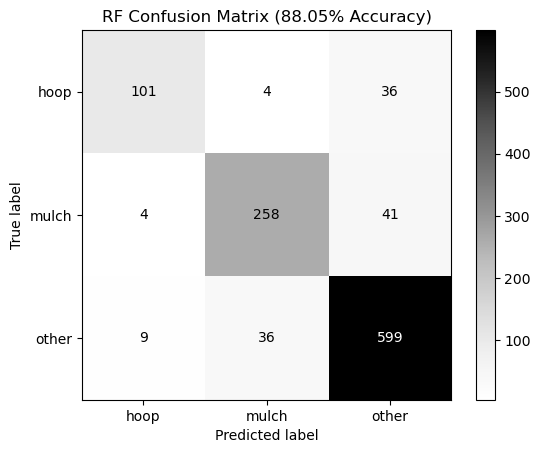

In [20]:
# Plot confusion matrix
display_labels = ["hoop", "mulch", "other"]

cm_RF = np.array(validationAccuracy_RF.getInfo())
disp = ConfusionMatrixDisplay(confusion_matrix=cm_RF, display_labels=display_labels)
disp.plot(cmap=plt.cm.Greys)
disp.ax_.set_title(f"RF Confusion Matrix ({validationAccuracy_RF.accuracy().getInfo():.2%} Accuracy)")

In [21]:
def plot_each_county_cm(cm_Counties):
  f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

  for i, (county, cm) in enumerate(cm_Counties.items()):
      disp = ConfusionMatrixDisplay(confusion_matrix=np.array(cm.getInfo()), display_labels=display_labels)
      disp.plot(ax=axes[i], cmap=plt.cm.Blues)
      disp.ax_.set_title(f"{county} ({cm.accuracy().getInfo():.2%} Accuracy)")
      disp.im_.colorbar.remove()
      disp.ax_.set_xlabel('')
      if i!=0:
          disp.ax_.set_ylabel('')

  f.text(0.4, 0.1, 'Predicted label', ha='left')
  plt.subplots_adjust(wspace=0.2, hspace=0.1)

  f.colorbar(disp.im_, ax=axes)
  plt.show()

In [22]:
filter_SantaMaria = ee.Filter.stringContains('county', 'Santa Maria')
filter_Mendocino = ee.Filter.stringStartsWith('county', 'Mendocino')
filter_Watsonville = ee.Filter.stringStartsWith('county', 'Watsonville')
filter_Oxnard = ee.Filter.stringStartsWith('county', 'Oxnard')

cm_SantaMaria = classifications_RF.filter(filter_SantaMaria).errorMatrix('class', 'classification')
cm_Mendocino = classifications_RF.filter(filter_Mendocino).errorMatrix('class', 'classification')
cm_Watsonville = classifications_RF.filter(filter_Watsonville).errorMatrix('class', 'classification')
cm_Oxnard = classifications_RF.filter(filter_Oxnard).errorMatrix('class', 'classification')
cm_Counties = {"Santa Maria": cm_SantaMaria, "Mendocino": cm_Mendocino, "Watsonville": cm_Watsonville, "Oxnard": cm_Oxnard}

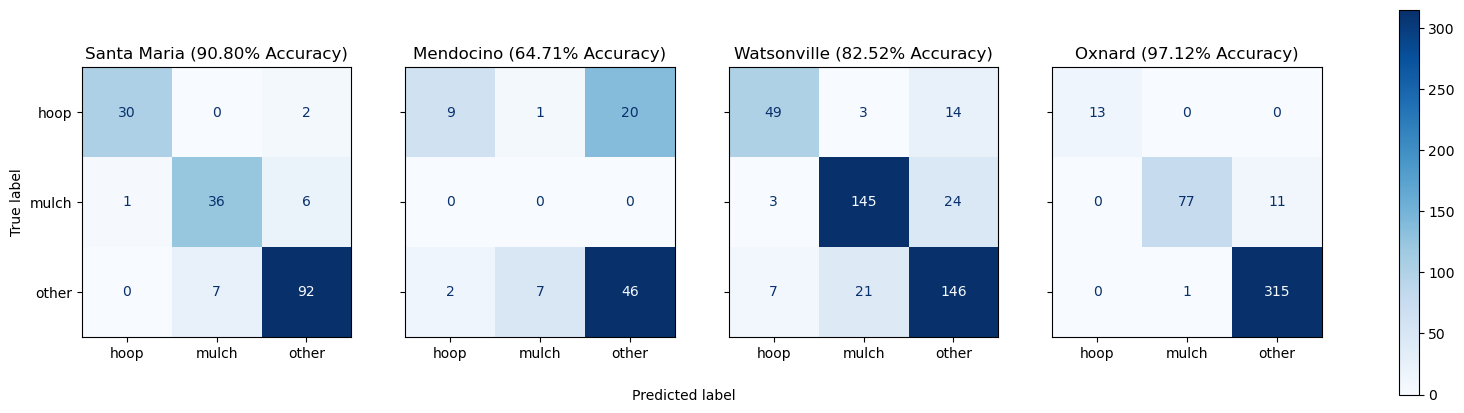

In [23]:
plot_each_county_cm(cm_Counties)

In [24]:
# this gives f score for each class (hoop, mulch, other)
validationAccuracy_RF.fscore().getInfo()

[0.7921568627450982, 0.8585690515806987, 0.9075757575757576]

#### Variable Importances

In [25]:
importance = ee.Dictionary(trained_RF.explain().get('importance'))

totalImportance = importance.values().reduce(ee.Reducer.sum())

# helper fn to map over importance values
def percentConvert(key, val):
    return ee.Number(val).divide(totalImportance).multiply(100)
relImportance = importance.map(percentConvert)

importanceFC = ee.FeatureCollection([ee.Feature(None, relImportance)])
# convert to pandas df
varImportance = geemap.ee_to_df(importanceFC)
varImportance

# varImportance.plot(kind='bar')
# plt.show()

,B11,B12,B2,B3,B4,B6,B8,NDTI,NDVI,PGI,PMLI,RPGI
0,8.702173,8.830947,7.549009,7.229636,7.628862,7.533575,7.955947,9.385461,9.132208,9.218081,8.184573,8.649529


#### Reproducible/condensed version
Useful for debugging

In [22]:
# # Reproducible version to test errors
# # import the training data - points labeled with class (0, 1, 2) and containing sampled band info
# asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/labeled_point_data' # needs to be read-only/public
# data = ee.FeatureCollection(asset_id)
# # subset the training data by approx 70% for training (and 30% for validation)
# training = data.filter(ee.Filter.lt('random', 0.7))
# bands = ['B4', 'B3', 'B2', 'B6', 'B8', 'B11', 'B12', 'NDVI', 'NDTI', 'PGI', 'RPGI', 'PMLI']

# trained_RF = ee.Classifier.smileRandomForest(50).train(training, 'class', bands)

# importance = ee.Dictionary(trained_RF.explain().get('importance'))

# totalImportance = importance.values().reduce(ee.Reducer.sum())

# # helper fn to map over importance values
# def percentConvert(key, val):
#     return ee.Number(val).divide(totalImportance).multiply(100)
# relImportance = importance.map(percentConvert)

# importanceFC = ee.FeatureCollection([ee.Feature(None, relImportance)])
# # convert to pandas df
# varImportance = geemap.ee_to_df(importanceFC)
# varImportance

### All models

In [31]:
# I'm not using this in the RF workflow, these are still used in the all models workflow
# def train_model(classifier, training, bands):
#   trained_classifier = classifier.train(training, 'class', bands)
#   return trained_classifier, trained_classifier.confusionMatrix()

# def evaluate_model(trained_classifier, validation):
#   classifications = validation.classify(trained_classifier)
#   return classifications, classifications.errorMatrix('class', 'classification')

In [ ]:
# # Train the models 
# # Model 1: SVM
# trained_SVM, trainAccuracy_SVM = train_model(ee.Classifier.libsvm(kernelType='RBF', gamma=0.5, cost=10), training, bands)
# _, validationAccuracy_SVM = evaluate_model(trained_SVM, validation)

# # Model 2: CART
# trained_CART, trainAccuracy_CART = train_model(ee.Classifier.smileCart(), training, bands)
# _, validationAccuracy_CART = evaluate_model(trained_CART, validation)

# # Model 3: RF
# trained_RF, trainAccuracy_RF = train_model(ee.Classifier.smileRandomForest(50), training, bands)
# classifications_RF, validationAccuracy_RF = evaluate_model(trained_RF, validation)

# # Model 4: GTB
# trained_GTB, trainAccuracy_GTB = train_model(ee.Classifier.smileGradientTreeBoost(50), training, bands)
# classifications_GTB, validationAccuracy_GTB = evaluate_model(trained_GTB, validation)


#### Model accuracies

In [59]:
# # Get their accuracies (train and validation)
# # takes ~10 min
# train_accuracies = [trainAccuracy_SVM.accuracy().getInfo(),
#                    trainAccuracy_CART.accuracy().getInfo(),
#                    trainAccuracy_RF.accuracy().getInfo(),
#                    trainAccuracy_GTB.accuracy().getInfo()]
# validation_accuracies = [validationAccuracy_SVM.accuracy().getInfo(),
#                         validationAccuracy_CART.accuracy().getInfo(),
#                         validationAccuracy_RF.accuracy().getInfo(),
#                         validationAccuracy_GTB.accuracy().getInfo()]

In [62]:
# # Report out
# print(f"SVM model \n training accuracy {train_accuracies[0]} \n validation accuracy {validation_accuracies[0]}")
# print(f"CART model \n training accuracy {train_accuracies[1]} \n validation accuracy {validation_accuracies[1]}")
# print(f"RF model \n training accuracy {train_accuracies[2]} \n validation accuracy {validation_accuracies[2]}")
# print(f"GDB model \n training accuracy {train_accuracies[3]} \n validation accuracy {validation_accuracies[3]}")

SVM model 
 training accuracy 1 
 validation accuracy 0.5795880149812734
CART model 
 training accuracy 1 
 validation accuracy 0.849250936329588
RF model 
 training accuracy 0.9961519961519961 
 validation accuracy 0.900749063670412
GDB model 
 training accuracy 0.9807599807599807 
 validation accuracy 0.8941947565543071


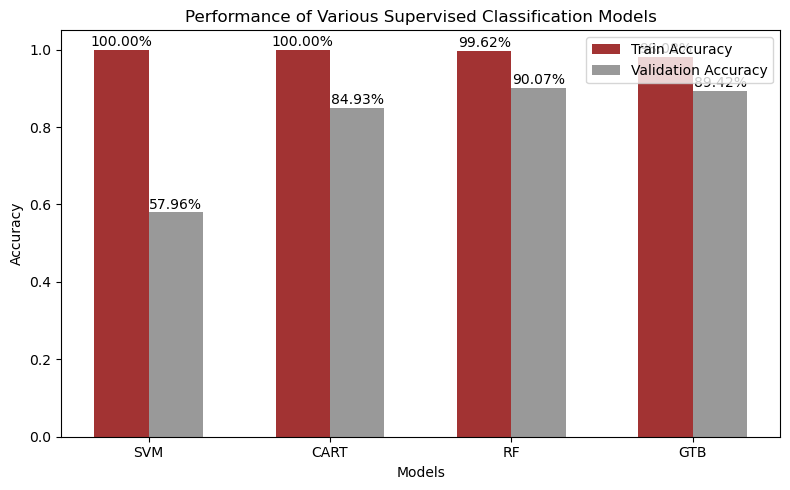

In [65]:
# model_names = ["SVM", "CART", "RF", "GTB"]
# # Define the width of each bar and the positions of the bars
# bar_width = 0.3
# index = np.arange(len(model_names))
# train_color = 'darkred'
# validation_color = 'grey'

# # Plotting
# plt.figure(figsize=(8, 5))
# bars1 = plt.bar(index, train_accuracies, bar_width, label='Train Accuracy', color=train_color, alpha=0.8)
# bars2 = plt.bar(index + bar_width, validation_accuracies, bar_width, label='Validation Accuracy', color=validation_color, alpha=0.8)

# # Add percentage values on top of the bars
# for bar1, bar2 in zip(bars1, bars2):
#     plt.text(bar1.get_x() + bar1.get_width() / 2, bar1.get_height() + 0.01, f'{bar1.get_height():.2%}', ha='center', color='black', fontsize=10)
#     plt.text(bar2.get_x() + bar2.get_width() / 2, bar2.get_height() + 0.01, f'{bar2.get_height():.2%}', ha='center', color='black', fontsize=10)

# plt.xlabel('Models')
# plt.ylabel('Accuracy')
# plt.title('Performance of Various Supervised Classification Models')
# plt.xticks(index + bar_width / 2, model_names)
# plt.legend()
# plt.tight_layout()
# plt.show()

# # Validation accuracies of CART, RF, and GTB are better here than in capstone notebook, SVM is worse

## 5. Export the model

per [ee docs](https://developers.google.com/earth-engine/apidocs/export-classifier-toasset#colab-python), allows you to build larger models (i.e. more trees, more training samples)

In [82]:
# rf_asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/RF_classifier'
# task = ee.batch.Export.classifier.toAsset(
#     classifier=trained_RF,
#     description='classifier_export',
#     assetId=rf_asset_id
# )
# task.start()

## 6. Apply model to imagery

In [26]:
# bring in the saved classifier
rf_asset_id = 'projects/ee-annalisertaylor/assets/TNC/agplastics/RF_classifier'
savedClassifier = ee.Classifier.load(rf_asset_id)

#### County boundaries for spatial filtering

In [27]:
# grab county boundaries for spatial filtering 
county_bnd = ee.FeatureCollection("TIGER/2016/Counties").filterBounds(ca)
# grab whatever counties you want
ventura = county_bnd.filter(ee.Filter.eq('NAME', 'Ventura'))
mendo = county_bnd.filter(ee.Filter.eq('NAME', 'Mendocino'))
cruz = county_bnd.filter(ee.Filter.eq('NAME', 'Santa Cruz'))
santabarbara = county_bnd.filter(ee.Filter.eq('NAME', 'Santa Barbara'))

# to read all the county options
# county_df = geemap.ee_to_df(county_bnd)
# pd.set_option('display.max_rows', 75)
# county_df['NAME']

#### Get all images from one date, stitch them together, and center the map on that

In [35]:
# to get all dates of imagery in a collection - will time out on a large collection
# turns out there is an image every day, so we don't need to use this/worry
# def getDate(image):
#     return ee.Feature(None, {'date': image.date().format('YYYY-MM-dd')})
# dates = sentinel2023.map(getDate).distinct('date').aggregate_array('date')
# dates
# there are 20-31 images per day in CA
# oneday = processedCollection.filterDate('2020-09-01', '2020-09-02').filterBounds(ca)
# oneday

# for a given date, get images from that date, stitch them together, and center the map on that
date = '2022-07-03'
nextday = ee.Date(date).advance(1, 'day').format('YYYY-MM-dd')
oneday = processedCollection.filterDate(date, nextday)

# these methods look identical to me in this case, even at image seams
# mosaic will take the last pixel first
mosaic = oneday.mosaic()
median = oneday.median()

# m = geemap.Map()
# # all pixel values are identical
# m.addLayer(oneday, rgbVis, 'Collection')
# m.addLayer(mosaic, rgbVis, 'Mosaic')
# m.addLayer(median, rgbVis, 'Median')
# m.centerObject(ca, 6)
# m

In [36]:
# visualize the classified plastic
landcover_palette = ['FF5733', 'F4F31D', '2596be']
plastic_viz = {
    'palette': landcover_palette,
    'min': 0,
    'max': 2,
    # 'format': 'png'
}

crops = crops.where(crops, 1)

# classify the image
classified = mosaic.classify(savedClassifier).updateMask(crops)

# TODO clip to my fields extent map created in pro

# add the classified plastic and composite image to map
m = geemap.Map()
# m.add_basemap('HYBRID')
m.addLayer(mosaic, rgbVis, 'Sentinel: ' + date)
m.addLayer(classified, plastic_viz, 'Classified Plastic')
m.centerObject(ca, 6)
m

# could add NDWI given possible confusion with flooded fields/water 
# chat with kirk about standing water with plastic mulch

Map(center=[37.152434104671315, -119.52655155150876], controls=(WidgetControl(options=['position', 'transparen…

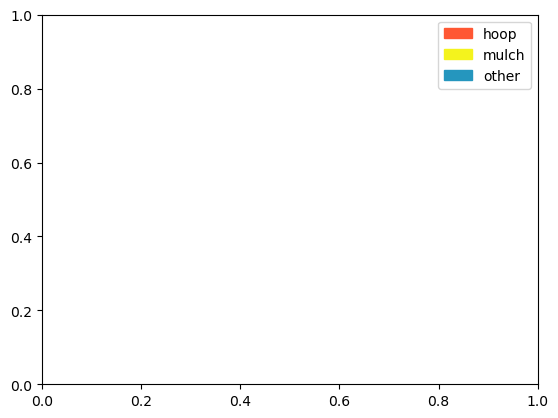

In [34]:
# Define the colors and labels
colors = ['#FF5733', '#F4F31D', '#2596be']
labels = ['hoop', 'mulch', 'other']

# Create a legend with the colors and labels
patches = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors]
plt.legend(patches, labels)

plt.show()